# Task 1, 2, 3:
## 1. completed, 
## 2. pending, 
## 3. finished but need to get opinion.

In [139]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import cv2

# output directory:  "../working/FILENAME"

'''
Direction
1. Load left/right images, Create np.array having same dimension, calling it as imgDisparity
2. Declare variables:
    searchWindowSize: also called BlockSize. it defines window size to calculate SSD between img1 and img2.
    maxDisparityRange: also called SearchBlockSize. it defines the rail searchWindow moves on. setup Max range.
3. Define functions: DisparitySSD:
    Might need another functions to find minimum SSD.
    args: img1, img2, searchWindow
    a. define searchWindowSize for applying to general use including edge/corner/boundary cases
    b. define disparityRange (index left and right) for same reason above.
       When doing this, disparity Index Left and right might be varying according to index (y, x), searchWindowSize.
    c. At each index (y,x) --> calculate SSD with index range (defined by c) in img2, which calculate SSDs (defined by b) 
    d. disparity value = y in img1 - y' (index found by SSD) --> Not sure calculate as is or additional operation like abs / square.
'''

def searchWindow(numRow, numCol, y, x, searchWindowSize):
    '''
    making general size confirm considering edge case
    args:
        numRow, numCol: shape of img1 array. they are boundary.
        y, x: row and column of img1
        X/Y searchWindowLength Left/Right/Top/Bottom: block length from center index (y, x) --> for edge cases
    '''
    ySearchWindowLengthTop = ySearchWindowLengthBottom = xSearchWindowLengthLeft = xSearchWindowLengthRight = searchWindowSize // 2
    
    if y - ySearchWindowLengthTop < 0:
        ySearchWindowLengthTop = y
    if y + ySearchWindowLengthBottom > numRow -1:
        ySearchWindowLengthBottom = numRow -1 -y
    if x - xSearchWindowLengthLeft < 0:
        xSearchWindowLengthLeft = x
    if x + xSearchWindowLengthRight > numCol -1:
        xSearchWindowLengthRight = numCol -1 -x
    return xSearchWindowLengthLeft, xSearchWindowLengthRight, ySearchWindowLengthTop, ySearchWindowLengthBottom
    

def disparityRangeCal(numRow, numCol, y, x, xSearchWindowLengthLeft, xSearchWindowLengthRight, disparityRange) -> (int, int):
    '''
    disparity calculation range according to each index
    args:
        numRow, numCol: shape of img1 array. they are boundary.
        y, x: row and column of img1
        disparityRange: adjusted odd value considering center. (this range will search both side)
        xSearchWindowLength Left/Right: To calculate addition.
    return:
        beginning and ending index of moving the center of searchWindow.
    '''
    disparityHalf = disparityRange // 2
    xSearchWindowLengthLeft = xSearchWindowLengthLeft
    xSearchWindowLengthRight = xSearchWindowLengthRight
    
    # Needed to consider two things.
    # 1. disparity range considering index (y, x) before considering searchWindowSize.
    xDisparityLeftIndex = max(x - disparityHalf, 0)
    xDisparityRightIndex = min(x + disparityHalf, numCol-1)

    # 2. Need to consider more according to searchWindowLength Left/Right
    if xDisparityLeftIndex - xSearchWindowLengthLeft < 0:
        xDisparityLeftIndex = xSearchWindowLengthLeft
    if xDisparityRightIndex + xSearchWindowLengthRight > numCol -1:
        xDisparityRightIndex = numCol -1 - xSearchWindowLengthRight    
    
    assert xDisparityLeftIndex <= xDisparityRightIndex, "It can not calculate. Disparity Left index is greater than Right based on the inputs"
        
    return xDisparityLeftIndex, xDisparityRightIndex


def minIdx(y, x, arraySSD, xDisparityLeftIndex, smoothnessThreshold):
    # Smoothness constraint
    # Considering the purpose of this is to find the index closest to original index.
    # split into two arrays including center(same index value as original) for both. 
    # length can be different.
    # then flip the left part. then each array index represents
    # how far is the position from the original index.
    # After finding min index using np.argmin, compare which one is smaller.
    arrayLeftSSD = arraySSD[0:x-xDisparityLeftIndex+1]
    arrayLeftSSD = np.flip(arrayLeftSSD)
    arrayRightSSD = arraySSD[x-xDisparityLeftIndex:]
    
    # Find argmin for subarray Left and Right.
    arrayLeftIdx = np.argmin(arrayLeftSSD)
    arrayRightIdx = np.argmin(arrayRightSSD)
    # If min values are less than smoothnessThreshold, just compare index to see 
    # which one is closer regardless 
    # Otherwise, compare min values, and pick the index having min value 
    if max(arrayLeftSSD[arrayLeftIdx], arrayRightSSD[arrayRightIdx]) <= smoothnessThreshold:
        if arrayLeftIdx <= arrayRightIdx:
            minIdxImg2 = x - arrayLeftIdx
        else:
            minIdxImg2 = x + arrayRightIdx
    else:
        if arrayLeftSSD[arrayLeftIdx] <= arrayRightSSD[arrayRightIdx]:
            minIdxImg2 = x - arrayLeftIdx
        else:
            minIdxImg2 = x + arrayRightIdx
    return minIdxImg2

def disparityMap(imgLeft, imgRight, searchWindowSize = 1, disparityRange = 10, smoothnessThreshold = 3):
    assert searchWindowSize > 0, "searchWindow should be bigger than 0(zero)"
    assert disparityRange > 0, "disparityRange should be bigger than 0(zero)"
    if disparityRange % 2 == 0:
        disparityRange -= 1
    if searchWindowSize % 2 == 0:
        searchWindowSize -= 1
    # imgLeft = cv2.GaussianBlur(imgLeft,(searchWindowSize,searchWindowSize),0)
    # imgRight = cv2.GaussianBlur(imgRight,(searchWindowSize,searchWindowSize),0)
    
    numRow, numCol = imgLeft.shape # because imgLeft is for template of imgDisparity 
    imgDisparity = np.zeros(imgLeft.shape, imgLeft.dtype)
    correspondanceMap = np.zeros(imgLeft.shape, imgLeft.dtype)

    for y in range(numRow):
        for x in range(numCol):
            xLengthLeft, xLengthRight, yLengthTop, yLengthBottom = searchWindow(numRow, numCol, y, x, searchWindowSize)
            xDisparityLeftIndex, xDisparityRightIndex = disparityRangeCal(numRow, numCol, y, x, xLengthLeft, xLengthRight, disparityRange)
            
            arraySSD = np.array([])
            imgLeft_temp = imgLeft[y-yLengthTop:y+yLengthBottom+1, x-xLengthLeft:x+xLengthRight+1]
            for j in range(xDisparityLeftIndex, xDisparityRightIndex+1):
                # correspondanceMap to filter index already used.
                # flag 1 after used. So, when the value of the index is 1
                # append infinity value to avoid from being selected.
                # the reason to append is to avoid any distortion of arraySSD index
                # which will be used to adjust index with regard to imgLeft index.
                # if correspondanceMap[y, j] == 1:
                #     arraySSD = np.append(arraySSD, np.inf)
                #     continue
                # print("y, x, j, yLengthTop, yLengthBottom, xLengthLeft, xLengthRight", y, x, j, yLengthTop, yLengthBottom, xLengthLeft, xLengthRight)
                imgRight_temp = imgRight[y-yLengthTop:y+yLengthBottom+1, j-xLengthLeft:j+xLengthRight+1]
                arraySSD = np.append(arraySSD, np.sum(np.square(imgLeft_temp - imgRight_temp)))
            
            minIdxImg2 = minIdx(y, x, arraySSD, xDisparityLeftIndex, smoothnessThreshold)
            
            # After finding the index corresponding to ImgLeft, set value at the index of ImgRight as 1
            # correspondanceMap[y, minIdxImg2] = 1

            disparityValue = np.abs(x - minIdxImg2)
            imgDisparity[y,x] = disparityValue

    imgDisparity = imgDisparity / np.max(imgDisparity)
    return imgDisparity

In [3]:
imgLeft = plt.imread("./H4_post_for_students/frameLeftgray.png")
imgRight = plt.imread("./H4_post_for_students/frameRightgray.png")


In [90]:
# Running time check.
import time
start_time = time.time()
imgDisparity1 = disparityMap(imgLeft, imgRight, searchWindowSize = 5, disparityRange = 10, smoothnessThreshold = 0.1)
print("--- {} seconds ---".format(time.time() - start_time))

start_time = time.time()
imgDisparity3 = disparityMap(imgLeft, imgRight, searchWindowSize = 10, disparityRange = 10, smoothnessThreshold = 0.1)
print("--- {} seconds ---".format(time.time() - start_time))

start_time = time.time()
imgDisparity5 = disparityMap(imgLeft, imgRight, searchWindowSize = 20, disparityRange = 10, smoothnessThreshold = 0.1)
print("--- {} seconds ---".format(time.time() - start_time))

imgDisparityControl = plt.imread("./H4_post_for_students/disparityMap_Matlab.png")

--- 51.45752692222595 seconds ---
--- 48.501389026641846 seconds ---
--- 50.914430141448975 seconds ---


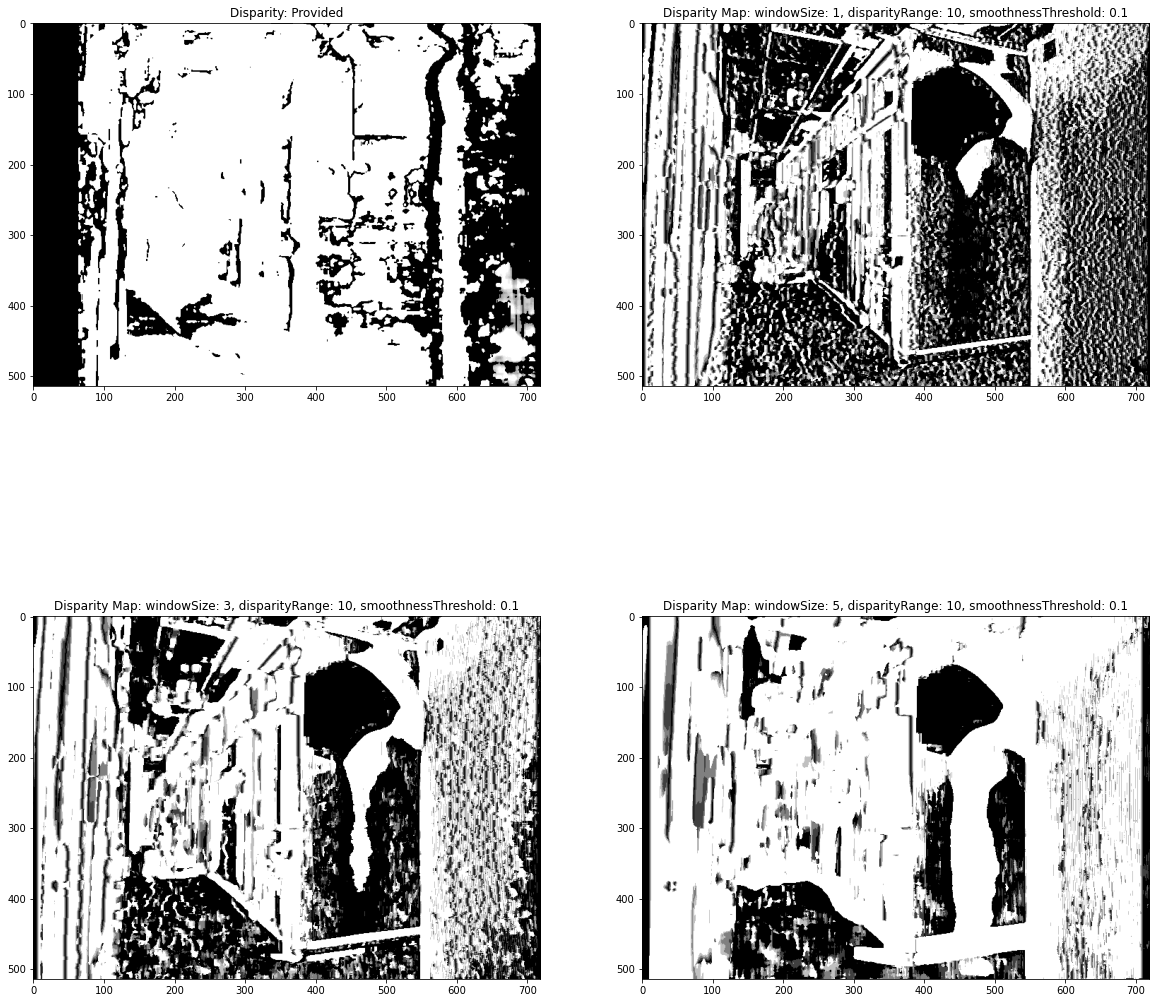

In [291]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.title("Disparity: Provided")
plt.imshow(imgDisparityControl, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Disparity Map: windowSize: 1, disparityRange: 10, smoothnessThreshold: 0.1")
plt.imshow(imgDisparity1, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Disparity Map: windowSize: 3, disparityRange: 10, smoothnessThreshold: 0.1")
plt.imshow(imgDisparity3, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Disparity Map: windowSize: 5, disparityRange: 10, smoothnessThreshold: 0.1")
plt.imshow(imgDisparity5, cmap='gray')

In [292]:
imgDisparity3_LR = imgDisparity3
imgDisparity3_RL = disparityMap(imgRight, imgLeft, searchWindowSize = 3, disparityRange = 10, smoothnessThreshold = 0.1)

In [89]:
np.max(imgDisparity3_LR.dtype), np.max(imgDisparity3_RL.dtype)

(dtype('float32'), dtype('float32'))

# Task 4: Generate outlier map - completed

In [93]:

# Call np.array instead of image file. Modify later if needed.
def outlierMap(imgLR, imgRL, indexThreshold=1):
    imgOutlier = np.zeros(imgLR.shape, imgLR.dtype)
    tempAbs = np.abs(imgLR - imgRL)
    imgOutlier[tempAbs >= indexThreshold] = 1
    return imgOutlier

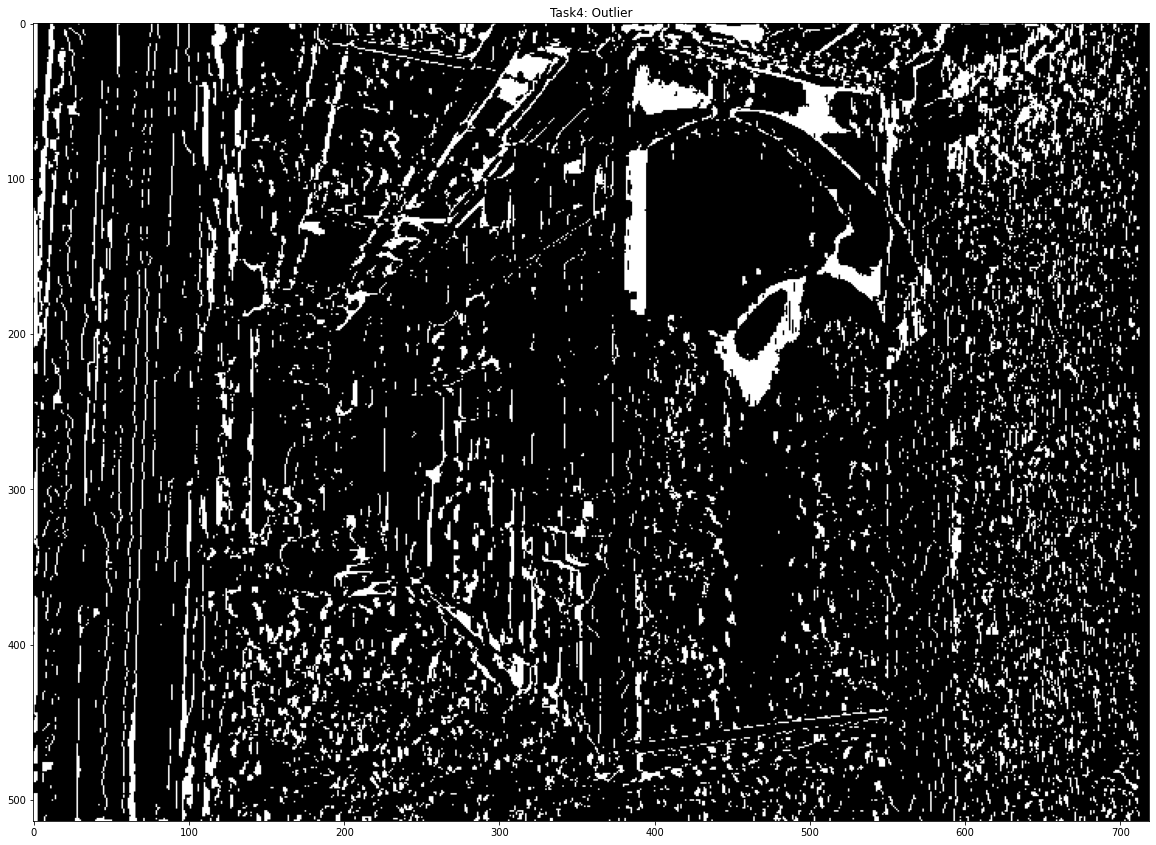

In [94]:
outlierMapImg = outlierMap(imgDisparity3_LR, imgDisparity3_RL, indexThreshold=1)

plt.figure(figsize=(20, 20))
plt.title("Task4: Outlier")
plt.imshow(outlierMapImg, cmap='gray')

# Task 5
## formula = $$d = f\frac{B}{Z}$$
**We know value Z from disparity Map, and should know B (baseline) and f (focal length measured in pixels). So, Depth Z is**
$$Z = f\frac{B}{d}$$
**From the equation above, key is finding the values, and convert values to have the same unit(mm or m ...). How to convert pixel info to this length info?**

**Update**
From the website: 
https://www.flir.com/support-center/iis/machine-vision/knowledge-base/how-is-depth-determined-from-a-disparity-image/

Maybe I don't need considering unit conversion from pixels to length(mm or m) if variables units are following. Diviging focal length by disparity, Z and B has the same unit
Z = distance along the camera Z axis
f = focal length (in pixels)
B = baseline (in metres)
d = disparity (in pixels)

In [290]:
# Load camera setting value we should use. Only provided .mat cannot be easily decoded. but an anonymous student provided modified version. downloaded it from Ed.
import scipy.io
parameters = scipy.io.loadmat('./stereoParams_py.mat')
# parameters

https://www.mathworks.com/help/vision/ref/cameraintrinsics.html#:~:text=FocalLength%20%E2%80%94%20Focal%20length&text=F%20is%20the%20focal%20length%20in%20world%20units%2C%20typically%20in,and%20fy%20are%20in%20pixels.

https://www.mathworks.com/help/vision/ref/cameraparameters.html


focalLength - Camera focal FocalLength
Camefa focal length, specified as a two-element vector [f_{x}, f_{y}]
$$f_{x} = F \times sx$$
$$f_{y} = F \times sy$$
F is the focal length in world units, typically mm. 
[sx, sy] are the number of pixels per world unit in the x and y direction respectively. 
f_x and f_y are in pixels.

PrincipalPoint - optical center of camera: specified as a two-element vector [cx, cy] in pixels.





In [125]:
# It might be more appropriate if we manipulate x, y, and z rather than only z to get distance.... but below function focused on getting z value.
# So, may something needed

def imgDistanceEstimate(parameters, imgLeft, imgDisparity, maxDistance):
    # x direction = column = imgLeft.shape[1]
    # Find focalLength. Disregarded CameraParameters2_FocalLength because the values are very similar
    # Maybe not consider focalLenth of y direction because two images are rectified, which means epipoles are parallel and there is no y direction disparity.
    focalLength = parameters["CameraParameters1_FocalLength"][0][0] / np.array([imgLeft.shape[1]])
    # print("focalLength is ", focalLength)
    # parameters["CameraParameters1_PrincipalPoint"], parameters["CameraParameters2_PrincipalPoint"]
    # Optical center distance aka Baseline
    opticalCenterDistance = np.sqrt(np.sum(np.square(parameters["CameraParameters1_PrincipalPoint"] - parameters["CameraParameters2_PrincipalPoint"])))
    # print("optical center distance is ", opticalCenterDistance)
    temp = focalLength * opticalCenterDistance / imgDisparity
    # print(temp[temp == np.inf])
    # print("np.max(temp)", np.max(temp))
    temp[temp == np.inf] = maxDistance
    return temp

In [126]:
imgDistance = imgDistanceEstimate(parameters, imgLeft, imgDisparity1, maxDistance = 30)

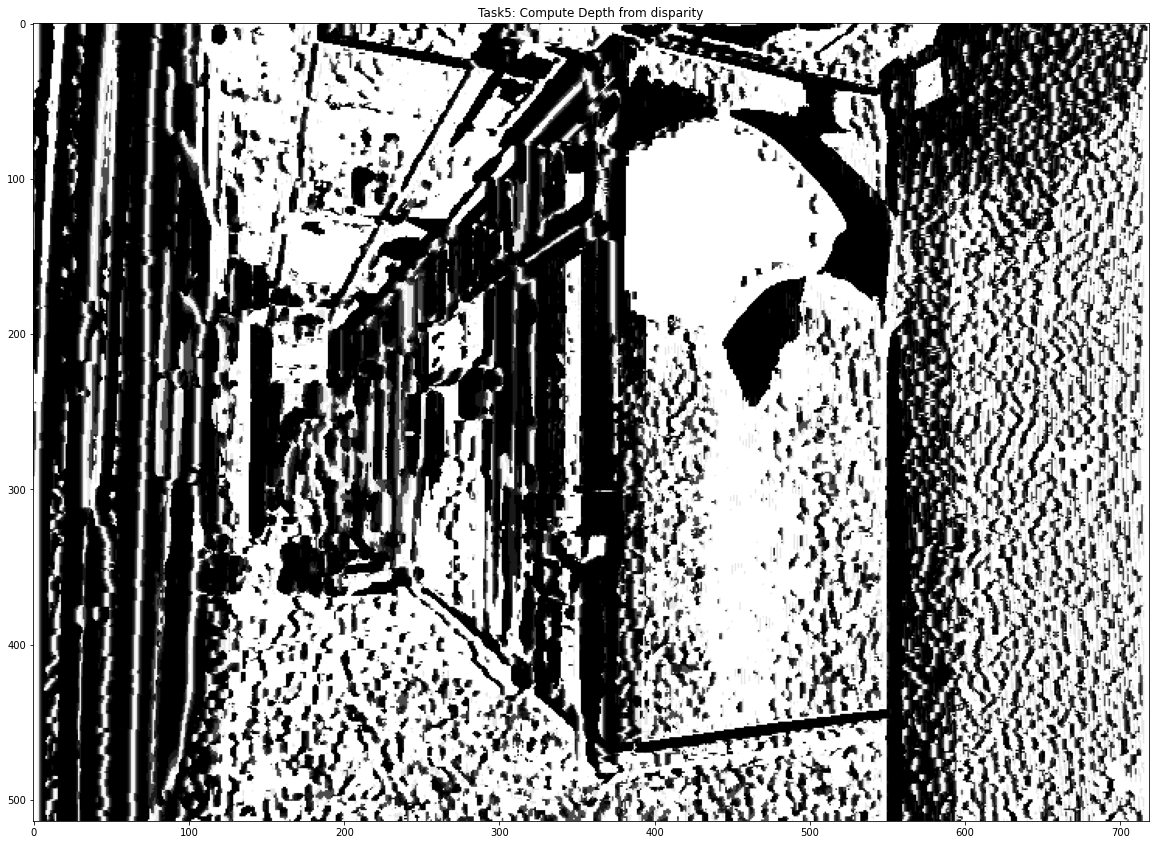

In [127]:
plt.figure(figsize=(20, 20))
plt.title("Task5: Compute Depth from disparity")
plt.imshow(imgDistance, cmap='gray')

# Task 6

In [131]:
def rgb2gray(rgbImg):
    # return np.dot(rgbImg[...,:3], [0.2989, 0.5870, 0.1140])
    return np.dot(rgbImg[:,:,3], [0.2989, 0.5870, 0.1140])

imLeft = rgb2gray(plt.imread("./H4_post_for_students/teddy/im2.png"))
imRight = rgb2gray(plt.imread("./H4_post_for_students/teddy/im6.png"))

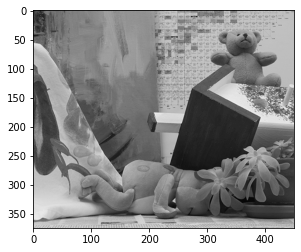

In [135]:
# plt.imshow(imLeft, cmap='gray')

In [148]:
imDisparityLR = disparityMap(imLeft, imRight, searchWindowSize = 1, disparityRange = 15, smoothnessThreshold = 0)
imDisparityRL = disparityMap(imRight, imLeft, searchWindowSize = 1, disparityRange = 15, smoothnessThreshold = 0)

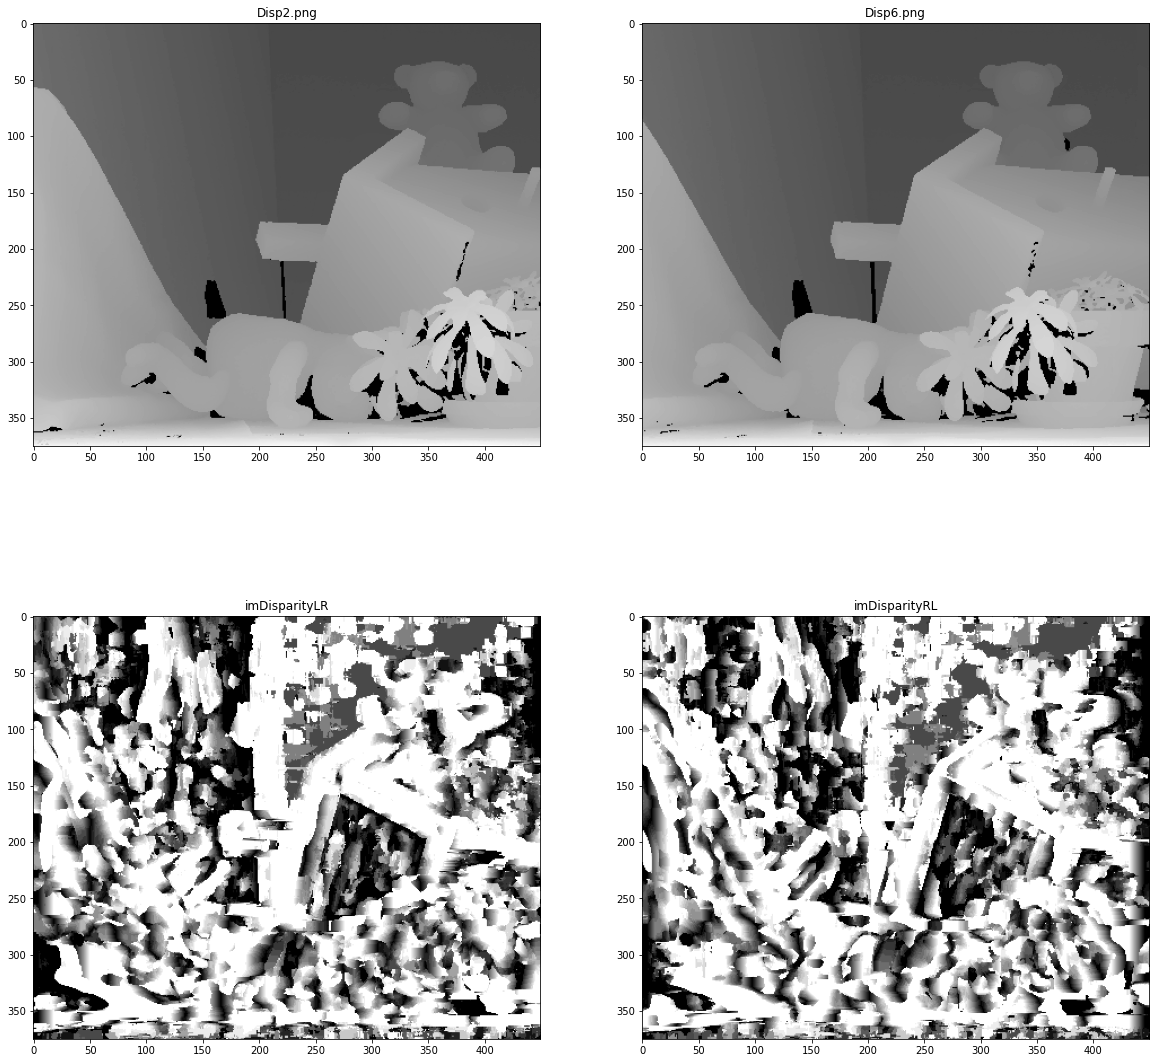

In [145]:
imDispRef2 = plt.imread("./H4_post_for_students/teddy/disp2.png")
imDispRef6 = plt.imread("./H4_post_for_students/teddy/disp6.png")

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.title("Disp2.png")
plt.imshow(imDispRef2, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Disp6.png")
plt.imshow(imDispRef6, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("imDisparityLR")
plt.imshow(imDisparityLR, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("imDisparityRL")
plt.imshow(imDisparityRL, cmap='gray')

# Task 7: Part A - Disparity matching along each epipolar lines

In [301]:
occ = 0.01
maxDisp = 64                                                            # where do I need this?
                                                                        
def stereoDP(imgLeftScanLine, imgRightScanLine, maxDisp, occ):                              # just used parameter names ScanLine, instead of epipolarLine
    backTrack = np.zeros((len(imgLeftScanLine), len(imgRightScanLine)), dtype='U2')         # String data type needs to cover at least 2 character (NW)
    costTable = np.zeros((len(imgLeftScanLine)+1, len(imgRightScanLine)+1))                 # cost table has one more row/colume. Be careful when manipulating both tables about index.

    # costTable initialization
    costTable[:, 0] = np.arange(len(imgRightScanLine)+1)*occ
    costTable[0, :] = np.arange(len(imgLeftScanLine)+1)*occ
    # for row in range(1, len(imgRightScanLine)+1):
    #     costTable[row, 0] = row * occ
    # for col in range(1, len(imgLeftScanLine)+1):
    #     costTable[0, col] = col * occ
    
    # costTable function for each row of imgLeft, imgRight. Also need to handle bTable simultaneously.
    
                                                                                
    # print(costTable)
    for row in range(1, len(imgRightScanLine)+1):
    # for row in range(1, 2):
        for col in range(1, len(imgLeftScanLine)+1):
            SSD = np.square(imgLeftScanLine[col-1] - imgRightScanLine[row-1])
            variableNW = costTable[row-1, col-1] + SSD
            variableW =  costTable[row, col-1] + occ
            variableN = costTable[row-1, col] + occ
            # print("row, col, square sum is {}, {}, {}".format(row, col, np.square(imgLeftScanLine[col-1] - imgRightScanLine[row-1])))
            if row == 1 and col == 1:
                # Since index of this starts from 1, not zero. value needs to be adjusted
                # And, because parameters of function is functon is each row array, no need to add row info for costTable.
                costTable[row, col] = SSD
            else:
                costTable[row, col] = min(variableNW, variableW, variableN)
                
            # backTrack update
            if costTable[row, col] == variableNW:
                backTrack[row-1, col-1] = 'NW'
                # print("min NW at row,col ({}, {})".format(row, col))
            elif costTable[row, col] == variableW:
                backTrack[row-1, col-1] = 'W'
            else:
                backTrack[row-1, col-1] = 'N'
    
    return costTable, backTrack

# costTable, backTrack = stereoDP(imgLeft[0], imgRight[0], maxDisp, occ)
# backTrack
# Moving on to part B


# Task 7: Part B: BackTracking

In [302]:
'''
By BackTracking, update disparityMapLeftRowDP, disparityMapRightRowDP
Needless to say, this function is for each row of images, not wholly 2D image.
'''
# print(backTrack.shape)

disparityMapLeftDP = np.zeros(imgLeft.shape, dtype=imgLeft.dtype)
disparityMapRightDP = np.zeros(imgRight.shape, dtype=imgRight.dtype)
    

def backTracking(disparityRow, costTable, backTrack):
    row = backTrack.shape[0] - 1
    col = backTrack.shape[1] - 1
    # print(row)
    while row > 0 or col > 0:
        # print("backTrack value is {}".format(backTrack[row, col]))
        if backTrack[row, col] == 'NW':
            # print("NW!!!!!")
            # Handle with costTable by adjusting suitable index (add +1 )
            disparityMapLeftDP[disparityRow, col] = costTable[row+1, col+1]
            disparityMapRightDP[disparityRow, row] = costTable[row+1, col+1]
            row -= 1
            col -= 1
        elif backTrack[row, col] == 'N':
            # occlusion case. No need to assign value zero because already disparityMapLeft/RightDP was created by np.zero
            # Update: need to change value to np.nan related to Task 7: Part C
            # However, to be clear in the future use, insert redundant code
            disparityMapLeftDP[disparityRow, col] = np.nan
            disparityMapRightDP[disparityRow, row] = np.nan
            row -= 1
        else:
            # Same as 'N' case in terms of treating value zero at this case
            # Update: same reason
            # it is disocculusion case.
            disparityMapLeftDP[disparityRow, col] = np.nan
            disparityMapRightDP[disparityRow, row] = np.nan
            col -= 1
        # print("row, col is {}, {}".format(row, col))


print("It took 1500 seconds (25~30min). So, be patient. I inserted print flag to see it's working. every 50 iterations")
print("Total row no is {}".format(imgLeft.shape[0]))
start_time = time.time()
for i in range(imgLeft.shape[0]):
    if i % 50 == 0:
        print("i is ", i)
    costTable, backTrack = stereoDP(imgLeft[i], imgRight[i], maxDisp, occ)
    backTracking(i, costTable, backTrack)
print("--- {} seconds ---".format(time.time() - start_time))

It took 1500 seconds (25~30min). So, be patient. I inserted print flag to see it's working. every 50 iterations
Total row no is 514
i is  0
i is  50
i is  100
i is  150
i is  200
i is  250
i is  300
i is  350
i is  400
i is  450
i is  500
--- 945.7266910076141 seconds ---


In [305]:
# How to apply disparityRow to test_disparityMapLeftDP
test_disparityMapLeftDP = np.zeros(imgLeft.shape, dtype=imgLeft.dtype)
test_disparityMapLeftDP[:,:] = np.nan                                           # declare variable and assign as np.nan before filling NW value selectively
                                                                                # Update: put this statment out from function that do work iteratively
def backTrackingII(disparityRow, costTableII, backTrackII):    
    backTrackIndexNW = np.argwhere(backTrackII == 'NW')                         # find 2D (row, column) index and these become element of backTrackIndexNW array
    rowIndexForBT = backTrackIndexNW[:, 0]                                      # extract row indexes
    columnIndexForBT = backTrackIndexNW[:, 1]                                   # extract column indexes
    test_disparityMapLeftDP[disparityRow,columnIndexForBT] = costTableII[rowIndexForBT+1, columnIndexForBT+1]       # +1 because indexes of costTableII matching others are +1 bigger


print("It took 1500 seconds (25~30min). So, be patient. I inserted print flag to see it's working. every 50 iterations")
print("Total row no is {}".format(imgLeft.shape[0]))
start_time = time.time()
for i in range(imgLeft.shape[0]):
    if i % 50 == 0:
        print("i is ", i)
    costTableII, backTrackII = stereoDP(imgLeft[i], imgRight[i], maxDisp, occ)
    backTrackingII(i, costTableII, backTrackII)
print("--- {} seconds ---".format(time.time() - start_time))

It took 1500 seconds (25~30min). So, be patient. I inserted print flag to see it's working. every 50 iterations
Total row no is 514
i is  0
i is  50
i is  100
i is  150
i is  200
i is  250
i is  300
i is  350
i is  400
i is  450
i is  500
--- 954.3209409713745 seconds ---


In [308]:
# test_disparityMapLeftDP.shape, disparityMapLeftDP.shape
test_disparityMapLeftDP, disparityMapLeftDP

(array([[1.8900154, 1.8800154, 2.7600307, ..., 2.0183852, 1.9528297,
         2.0072742],
        [0.87     , 1.8800154, 2.9000769, ..., 1.9974164, 1.9923683,
         2.0373511],
        [0.83     , 2.9300153, 2.9200308, ..., 2.1047251, 2.0997078,
         2.0946906],
        ...,
        [0.64     , 5.5000153, 5.490031 , ..., 1.6463437, 1.6386813,
         1.6309881],
        [0.64     , 0.63     , 5.4900155, ..., 1.6416532, 1.6332988,
         1.6252673],
        [0.63     , 0.6300154, 5.490031 , ..., 1.6524799, 1.6436332,
         1.6352633]], dtype=float32),
 array([[0.        , 1.8900154 , 2.1800308 , ..., 1.9298154 , 1.9528297 ,
         2.0072742 ],
        [0.        , 0.73006153, 0.830123  , ..., 1.9689081 , 1.9923683 ,
         2.0373511 ],
        [0.        , 0.70001537, 0.70003074, ..., 2.0547252 , 2.0797079 ,
         2.0946906 ],
        ...,
        [0.        , 0.01650135, 0.23034218, ..., 1.6306037 , 1.6308497 ,
         1.6309881 ],
        [0.        , 0.0170396 , 

# Task 7: part C: Displaying the disparity map, again
## continue with disparityMapLeftDP

In [312]:
# Since non disparity index were filled with np.nan, it should be treated to map enough to apply imshow.

#  1. Map disparity into the range [0, 1]
# Caution: Don't use np.min because nan vaule will be max and min. Need to exclude nan value
maxD, minD = np.nanmax(test_disparityMapLeftDP), np.nanmin(test_disparityMapLeftDP)
scaleD = 1 / (maxD - minD)
scaledDisparity = scaleD * test_disparityMapLeftDP

# 2. Colorized occuluded pixels to be red
# Declare dColor having 3 channel (RGB). Everything else is same property as scaledDisparity
# Then, assign each channel layer (R, G, B) as same value as scaledDisparity
# When applyting values of scaledDisparity to channel layer, index having value np.nan will be changed to Red color.

dColor = np.zeros((scaledDisparity.shape[0], scaledDisparity.shape[1], 3), dtype=scaledDisparity.dtype)
dColor[:,:,0] = np.where(np.isnan(scaledDisparity), 1, scaledDisparity)
dColor[:,:,1] = np.where(np.isnan(scaledDisparity), 0, scaledDisparity)
dColor[:,:,2] = np.where(np.isnan(scaledDisparity), 0, scaledDisparity)

array([[0.2709049 , 0.26947156, 0.39560834, ..., 0.28930476, 0.2799084 ,
        0.28771216],
       [0.12470125, 0.26947156, 0.41568184, ..., 0.2862992 , 0.28557563,
        0.29202324],
       [0.11896785, 0.41997305, 0.4185419 , ..., 0.30168027, 0.30096114,
        0.30024198],
       ...,
       [0.09173425, 0.78834337, 0.78691226, ..., 0.23597828, 0.23487999,
        0.2337773 ],
       [0.09173425, 0.0903009 , 0.78691006, ..., 0.23530596, 0.2341085 ,
        0.23295729],
       [0.0903009 , 0.0903031 , 0.78691226, ..., 0.23685782, 0.23558977,
        0.23439008]], dtype=float32)

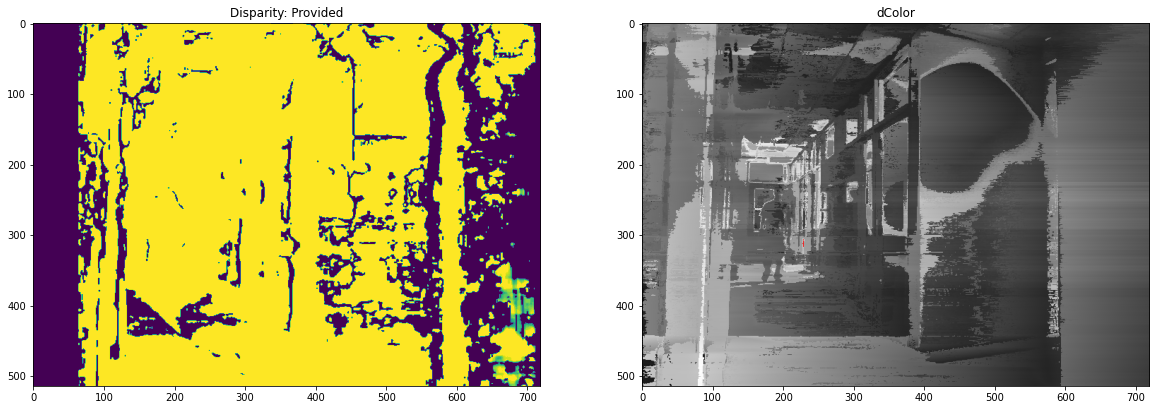

In [310]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.title("Disparity: Provided")
plt.imshow(imgDisparityControl)

plt.subplot(2, 2, 2)
plt.title("dColor")
plt.imshow(dColor)